In [1]:
#py_geospatial env
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import process_ISIMIP as pISIMIP

from typing import Any, Dict, List, Tuple
import os, uuid, time, gc
import geopandas as gpd
import pickle

# autoreload imports
%load_ext autoreload
%autoreload 2

#segoe ui
plt.rcParams['font.family'] = 'Segoe UI'

#### Merge ISIMIP datasets for each scenario
Since ISIMIP data is downloaded in time chunks, these chunks need to be merged for each variable and scenario to make further analysis more convenient.  
For each GCM, this code block merges all the chunks for each variable and scenario to one dataset.  

This is only done once.

In [ ]:
#source for ISIMIP data
src_isimip = r"D:/VUB/_data/_isimip_3b"

#source for EOBS data (observed)
src_obs = r'D:/VUB/_data/mHM_EOBS'

#Data already clipped to domain boundaries
tmax_EOBS = xr.open_dataset(f'{src_obs}/tmax.nc')
tmin_EOBS = xr.open_dataset(f'{src_obs}/tmin.nc')
pr_EOBS = xr.open_dataset(f'{src_obs}/pre.nc')


models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))

#select only scenarios to model
scenarios = ['historical', 'ssp370', 'ssp585']
variables = ['pr', 'tasmin', 'tasmax']

# Merge ISIMIP data chunks for each scenario
pISIMIP.merge_ISIMIP_datasets(src_isimip, models, scenarios, variables, verbose=False)

#### Import obs. data and compare with GCM data

In [3]:


#slice future periods by time window of interest
"""Customize as necessary"""
historical_periods = slice("1971-01-01", "2010-12-31")
future_periods = slice("2061-01-01", "2100-12-31")

#store ISIMIP data in a dictionary
isimip_data = {}

#Open the datasets for each model and scenario and slice accordingly
for model in models:
    for scenario in scenarios:
        for variable in variables:
            file_path = f"{src_isimip}/{model}/{scenario}/{model}_{variable}_merged.nc"
            if glob.glob(file_path):
                data = xr.open_dataset(file_path)
                if scenario == 'historical':
                    isimip_data[f'{model}_{scenario}_{variable}'] = data.sel(time=historical_periods)
                else:
                    isimip_data[f'{model}_{scenario}_{variable}'] = data.sel(time=future_periods)

#### Extract data for comparison plots

In [4]:
tasmax_dfs= []
tasmax_fut_dfs = []
tasmin_dfs = []
pr_dfs = []
for model in models:
    tasmin_hist = isimip_data[f"{model}_historical_tasmin"]
    tasmax_ssp585 = isimip_data[f"{model}_ssp585_tasmax"]
    tasmax_hist = isimip_data[f"{model}_historical_tasmax"]
    pr_hist = isimip_data[f"{model}_historical_pr"]
    

    #extract tmin and tmax over a grid
    tasmin_hist_df = (tasmin_hist['tasmin']-273.15).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_tasmin')
    tasmax_hist_df = (tasmax_hist['tasmax']-273.15).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_tasmax')
    tasmax_EOBS_df = (tmax_EOBS['tmax']-273.15).mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_tasmax')
    tasmax_ssp585_df = (tasmax_ssp585['tasmax']-273.15).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_ssp585_tasmax')
    pr_hist_df = (pr_hist['pr']*86400).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_pr')

    #append to list
    tasmax_dfs.append(tasmax_hist_df)
    tasmin_dfs.append(tasmin_hist_df)
    tasmax_fut_dfs.append(tasmax_ssp585_df)
    pr_dfs.append(pr_hist_df)

tasmax_hist_df = pd.concat(tasmax_dfs, axis=1)
tasmin_hist_df = pd.concat(tasmin_dfs, axis=1)
pr_hist_df = pd.concat(pr_dfs, axis=1)
tasmax_fut_df = pd.concat(tasmax_fut_dfs, axis=1)

tasmin_EOBS_df = tmin_EOBS['tmin'].mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_tasmin')
tasmax_EOBS_df = tmax_EOBS['tmax'].mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_tasmax')
pr_EOBS_df = pr_EOBS['pre'].mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_pr')

#### Comparison Plots

Text(0, 0.5, 'Temperature ($^0$C)')

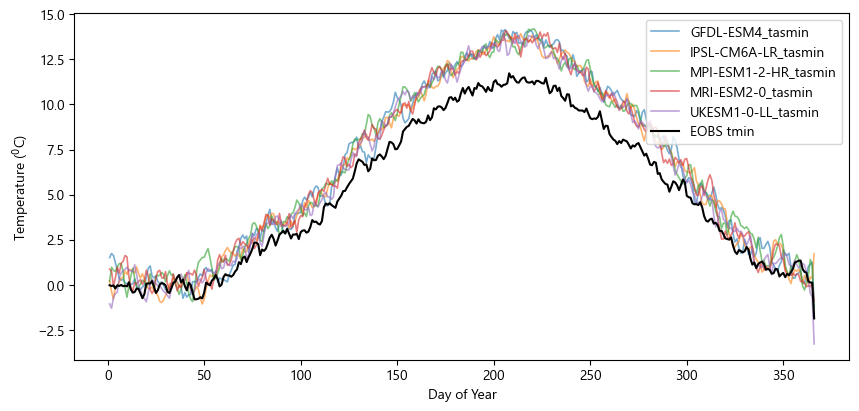

In [5]:

fig, ax = plt.subplots(figsize=(10, 4.5))

# Plotting the data
plt.plot(tasmin_hist_df.groupby(tasmin_hist_df.index.dayofyear).mean(), label=tasmin_hist_df.columns, alpha=0.6, lw=1.2)
plt.plot(tasmin_EOBS_df.groupby(tasmin_EOBS_df.index.dayofyear).mean(), color='k', label='EOBS tmin')
#plt.plot(tmin_future_df_.groupby(tmax_future_df_.index.dayofyear).mean(), label=tmax_future_df_.columns, alpha=0.6, lw=1.2, c='orange')
plt.legend(loc='upper right', ncol=1)
plt.xlabel('Day of Year')
plt.ylabel('Temperature ($^0$C)')

Text(0, 0.5, 'Precipitation (mm/day)')

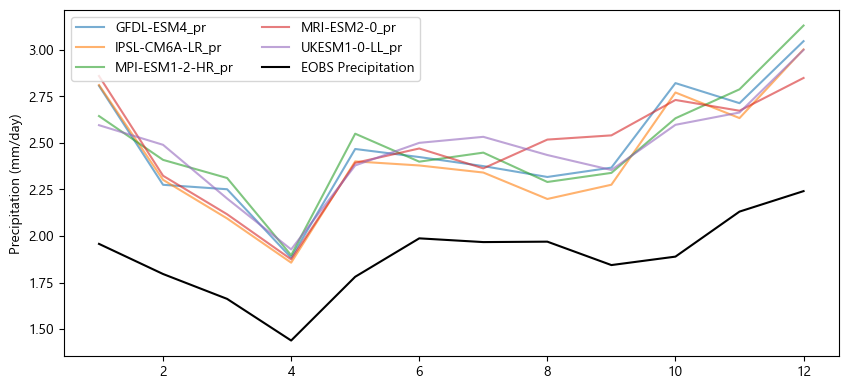

In [6]:
#Rainfall data

fig, ax = plt.subplots(figsize=(10, 4.5))

plt.plot(pr_hist_df.groupby(pr_hist_df.index.month).mean(), label=pr_hist_df.columns, alpha=0.6)
plt.plot(pr_EOBS_df.groupby(pr_EOBS_df.index.month).mean(), color='k', label='EOBS Precipitation')
plt.legend(loc='upper left', ncol=2)
plt.ylabel('Precipitation (mm/day)')

#### Regrid ISIMIP data to match resolution of observed data

#### Regrid ISIMIP with XESMF

   1. Precipitation

In [7]:
#regrid climate data to EOBS grid
# ----------------------------
# Settings you can tweak
# ----------------------------
REGRID_METHOD = "bilinear"          # "bilinear" for rates; use "conservative_normed" for totals
VAR_NAME = "pr"              # precipitation variable key in your isimip_data
VAR_UNITS = "mm/day"         # CF-ish units string
VAR_STDNAME = "precipitation_flux"
long_name = "Regridded precipitation rate"
# -----------------------------------

obs_pre = pISIMIP.select_ref_hist(pr_EOBS, 'pre', '1971-01-01', '2010-12-31') #Overlap with historical_period for ISIMIP data

isimip_regridded_pr = pISIMIP.regrid_ISIMIP_to_obs(isimip_data, obs_pre, models, scenarios, REGRID_METHOD,
                                             VAR_NAME, VAR_UNITS, VAR_STDNAME, long_name)


#Get rid of empty rows and columns in the regridded data
# -----------------------------------
isimip_hiRES_pr = {}

#mask and drop empty rows/cols
for name, data in isimip_regridded_pr.items():

        #cells that are valid at least once over time
        valid = data.notnull().any("time")

        # mask and drop empty rows/cols
        data_valid = data.where(valid).dropna("lat", how="all").dropna("lon", how="all")     

        isimip_hiRES_pr[name] = data_valid


2. Temperature

In [8]:
#regrid climate data to EOBS grid
# ----------------------------
# Settings you can tweak
# ----------------------------
REGRID_METHOD = "bilinear"          # "bilinear" for rates; use "conservative_normed" for totals
VAR_NAME = "tasmax"              # precipitation variable key in your isimip_data
VAR_UNITS = "degree-celcius"         # CF-ish units string
VAR_STDNAME = "Maximum daily air temperature"
long_name = "Regridded maximum daily air temperature"
# -----------------------------------

obs_tmax = pISIMIP.select_ref_hist(tmax_EOBS, 'tmax', '1971-01-01', '2010-12-31') #Overlap with historical_period for ISIMIP data

isimip_regridded_tasmax = pISIMIP.regrid_ISIMIP_to_obs(isimip_data, obs_tmax, models, scenarios, REGRID_METHOD,
                                             VAR_NAME, VAR_UNITS, VAR_STDNAME, long_name)


#Get rid of empty rows and columns in the regridded data
# -----------------------------------
isimip_hiRES_tmax= {}

#mask and drop empty rows/cols
for name, data in isimip_regridded_tasmax.items():

        #cells that are valid at least once over time
        valid = data.notnull().any("time")

        # mask and drop empty rows/cols
        data_valid = data.where(valid).dropna("lat", how="all").dropna("lon", how="all")

        #rename tasmax, tasmin variable to tmax, tmin
        #data_valid = data_valid.rename({'tasmax': 'tmax'})


        isimip_hiRES_tmax[name] = data_valid

In [9]:
#regrid climate data to EOBS grid
# ----------------------------
# Settings you can tweak
# ----------------------------
REGRID_METHOD = "bilinear"          # "bilinear" for rates; use "conservative_normed" for totals
VAR_NAME = "tasmin"              # variable key in isimip_data
VAR_UNITS = "degree-celcius"         # CF-ish units string
VAR_STDNAME = "Minimum daily air temperature"
long_name = "Regridded minimum daily air temperature"
# -----------------------------------

obs_tmin = pISIMIP.select_ref_hist(tmin_EOBS, 'tmin', '1971-01-01', '2010-12-31')

isimip_regridded_tasmin = pISIMIP.regrid_ISIMIP_to_obs(isimip_data, obs_tmin, models, scenarios, REGRID_METHOD,
                                             VAR_NAME, VAR_UNITS, VAR_STDNAME, long_name)


#Get rid of empty rows and columns in the regridded data
# -----------------------------------
isimip_hiRES_tmin= {}

#mask and drop empty rows/cols
for name, data in isimip_regridded_tasmin.items():

        #cells that are valid at least once over time
        valid = data.notnull().any("time")

        # mask and drop empty rows/cols
        data_valid = data.where(valid).dropna("lat", how="all").dropna("lon", how="all")

        #rename tasmax, tasmin variable to tmax, tmin
        #data_valid = data_valid.rename({'tasmin': 'tmin'})

        isimip_hiRES_tmin[name] = data_valid

#### Bias correct regridded ISIMIP data with QDM

##### Precipitation

In [10]:

models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
future_scenarios = ['ssp370', 'ssp585']
method= 'qdm'  # Choose 'qdm' for Quantile Delta Mapping or 'eqm' for Empirical Quantile Mapping
kind = "*"  # Use "+" for temperature or "*" for precipitation
VAR_NAME, VAR_UNITS, VAR_STDNAME= 'pr', 'mm/day', 'precipitation_flux'

# Bias correct the regridded ISIMIP data
"""QDM"""
isimip_bc_precip = pISIMIP.bias_correct_ISIMIP(isimip_hiRES_pr, obs_pre, models,
                                     future_scenarios, method=method, VAR_NAME=VAR_NAME, VAR_UNITS=VAR_UNITS, VAR_STDNAME=VAR_STDNAME, kind=kind)

"""EDM"""
# isimip_bc_EQM = pISIMIP.bias_correct_ISIMIP(isimip_regridded_pr, obs_precip, models,
#                                      future_scenarios, method=method)

'EDM'

##### tmax

In [ ]:

models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
future_scenarios = ['ssp370', 'ssp585']
method= 'qdm'  # Choose 'qdm' for Quantile Delta Mapping or 'eqm' for Empirical Quantile Mapping
kind = "+"  # Use "+" for temperature or "*" for precipitation
VAR_NAME, VAR_UNITS, VAR_STDNAME= 'tasmax', 'degree_celsius', 'max. daily temperature'

# Bias correct the regridded ISIMIP data
"""QDM"""

isimip_bc_tmax = pISIMIP.bias_correct_ISIMIP(isimip_hiRES_tmax, obs_tmax, models,
                                     future_scenarios, method=method, VAR_NAME=VAR_NAME, VAR_UNITS=VAR_UNITS, VAR_STDNAME=VAR_STDNAME, kind=kind)

"""EDM"""
# isimip_bc_EQM = pISIMIP.bias_correct_ISIMIP(isimip_regridded_pr, obs, models,
#                                      future_scenarios, method=method)

#### tmin

In [12]:

models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
future_scenarios = ['ssp370', 'ssp585']
method= 'qdm'  # Choose 'qdm' for Quantile Delta Mapping or 'eqm' for Empirical Quantile Mapping
kind = "+"  # Use "+" for temperature or "*" for precipitation
VAR_NAME, VAR_UNITS, VAR_STDNAME= 'tasmin', 'degree_celsius', 'min. daily temperature'

# Bias correct the regridded ISIMIP data
"""QDM"""

isimip_bc_tmin = pISIMIP.bias_correct_ISIMIP(isimip_hiRES_tmin, obs_tmin, models,
                                     future_scenarios, method=method, VAR_NAME=VAR_NAME, VAR_UNITS=VAR_UNITS, VAR_STDNAME=VAR_STDNAME, kind=kind)

"""EDM"""
# isimip_bc_EQM = pISIMIP.bias_correct_ISIMIP(isimip_regridded_pr, obs, models,
#                                      future_scenarios, method=method)

'EDM'

#### Calculate average daily temperature (tavg)

In [13]:
#calculate tasavg
# -----------------------------------

isimip_bc_tavg = {}
# Loop through each model and scenario to calculate tasavg
scenarios = ['historical', 'ssp370', 'ssp585']

for model in models:
    for scenario in scenarios:
        tasmin = isimip_bc_tmin[f'{model}_{scenario}_tasmin']['tasmin']
        tasmax = isimip_bc_tmax[f'{model}_{scenario}_tasmax']['tasmax']
        tasavg = (tasmin + tasmax) / 2

        #change to xrDataset
        tasavg = tasavg.to_dataset(name='tavg')

        attributes = {
            'units': 'degree_celcius',
            'standard_name': 'Average daily air temperature',
            'long_name': f'Average daily air temperature for {model} {scenario}'
             
        }

        tasavg.attrs.update(attributes)

        isimip_bc_tavg[f'{model}_{scenario}_tavg'] = tasavg

Text(0.5, 0, 'Day of Year')

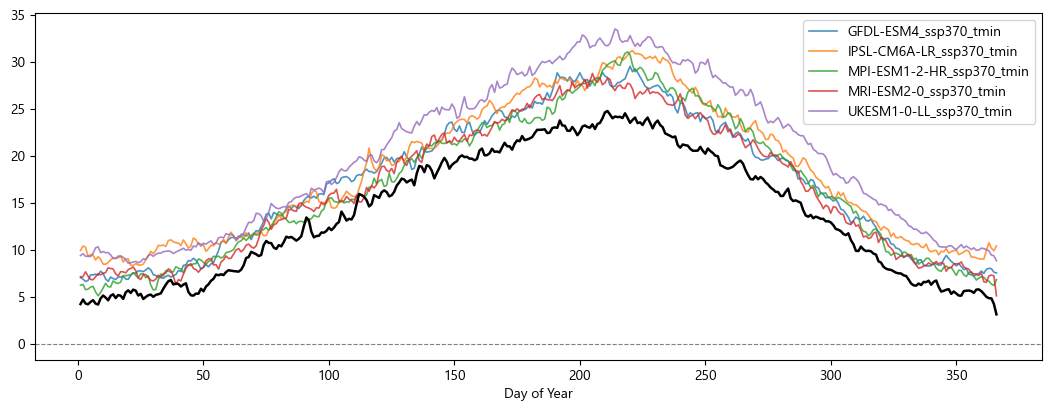

In [71]:
fig, ax = plt.subplots(figsize=(13, 4.5))

df_obs = obs_tmax.mean(dim=['lat', 'lon']).to_dataframe()

for model in models:
    tasmax_hist = isimip_bc_tmax[f"{model}_ssp370_tmax"]
    tasmax_hist_df = tasmax_hist.mean(dim=['lat', 'lon']).to_dataframe()

    plt.plot(tasmax_hist_df.groupby(tasmax_hist_df.index.dayofyear).mean(), label=model+'_ssp370_tmin', lw=1.2, alpha=0.8)

plt.legend(loc='upper right', ncol=1)
plt.plot(df_obs.groupby(df_obs.index.dayofyear).mean(), color='k', label='EOBS tmax', lw=1.8)
plt.axhline(0, color='gray', lw=0.8, ls='--')
plt.xlabel('Day of Year')

Text(0.5, 0, 'Month')

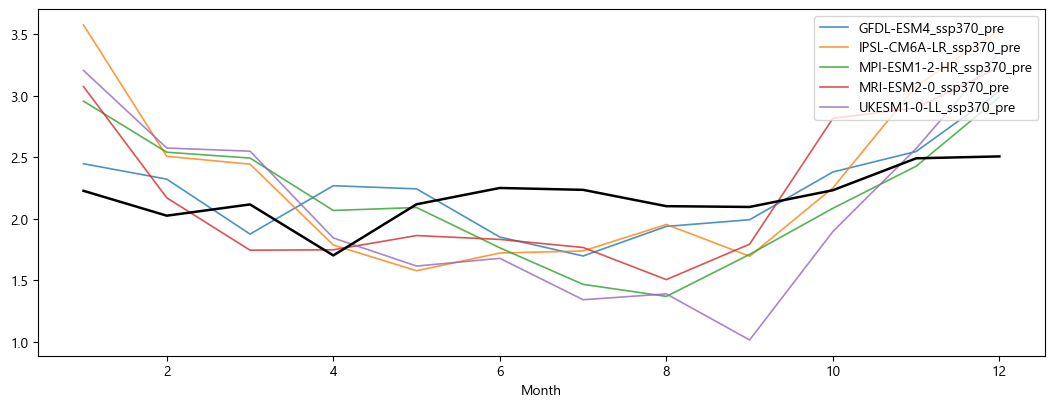

In [76]:
fig, ax = plt.subplots(figsize=(13, 4.5))

df_obs = obs_pre.mean(dim=['lat', 'lon']).to_dataframe()

for model in models:
    tasmax_hist = isimip_bc_precip[f"{model}_ssp585_pre"]
    tasmax_hist_df = tasmax_hist.mean(dim=['lat', 'lon']).to_dataframe()

    plt.plot(tasmax_hist_df.groupby(tasmax_hist_df.index.month).mean(), label=model+'_ssp370_pre', lw=1.2, alpha=0.8)

plt.legend(loc='upper right', ncol=1)
plt.plot(df_obs.groupby(df_obs.index.month).mean(), color='k', label='EOBS tmax', lw=1.8)
#plt.axhline(0, color='gray', lw=0.8, ls='--')
plt.xlabel('Month')

##### Rename variable to mHM format
pr to pre, tasmax to tmax, tasmin to tmin

In [ ]:
# precip → pre
isimip_bc_precip = {
    key.replace("pr", "pre"): data.rename({"pr": "pre"})
    for key, data in isimip_bc_precip.items()
}

# tmax → tmax
isimip_bc_tmax = {
    key.replace("tasmax", "tmax"): data.rename({"tasmax": "tmax"})
    for key, data in isimip_bc_tmax.items()
}

# tmin → tmin
isimip_bc_tmin = {
    key.replace("tasmin", "tmin"): data.rename({"tasmin": "tmin"})
    for key, data in isimip_bc_tmin.items()
}


In [79]:
isimip_bc_tmin['GFDL-ESM4_ssp370_tmin']

<xarray.Dataset> Size: 222MB
Dimensions:  (lat: 52, lon: 73, time: 14609)
Coordinates:
  * lat      (lat) float64 416B 51.75 51.69 51.62 51.56 ... 48.69 48.62 48.56
  * lon      (lon) float64 584B 2.25 2.312 2.375 2.438 ... 6.625 6.688 6.75
  * time     (time) datetime64[ns] 117kB 2061-01-01 2061-01-02 ... 2100-12-31
Data variables:
    tmin     (time, lat, lon) float32 222MB nan nan nan ... 3.435 3.352 3.303
Attributes:
    source:                  GFDL-ESM4 ISIMIP3b
    source_scenario:         ssp370
    bias_correction_method:  QDM

#### Export to scenarios to NetCDF

Exports the scenario data into respective per model per scenario. This step only needs to be run if the processing steps above change.
These outputs are for mHM simulation which we have to maintain the folder order.

In [37]:
###     Export the bias-corrected data to NetCDF files
# -----------------------------------
export_scenarios = ['historical', 'ssp370', 'ssp585']
variable = 'pre'
dataset_dict = isimip_bc_precip  # Use the bias-corrected precipitation data or regridded tasmin/max
dest_isimip = "D:/VUB/_data/_isimip_3b/bias_corrected"
#create if not exists
if not os.path.exists(dest_isimip):
    os.makedirs(dest_isimip)
#isimip_dict = isimip_bc_QDM


#export the regridded tasmin data

pISIMIP.export_scenarios_to_netcdf(dataset_dict, dest_isimip, export_scenarios, models, variable)

